In [1]:
import pandas as pd
from pathlib import Path

path = Path("datasets/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)
df = df.drop_duplicates()

In [2]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


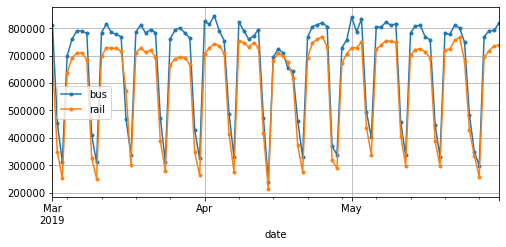

In [3]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
plt.show()

Due to weekly seasonaility, a reasonable naive guess would be to predict that the ridership today will be identical to one week ago.

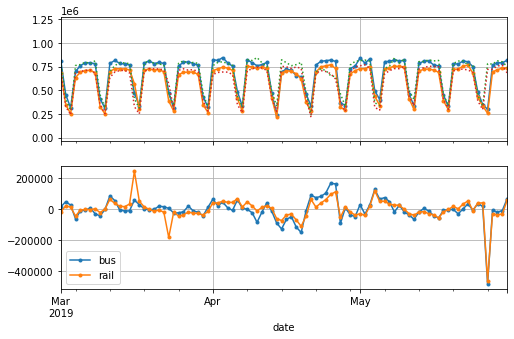

In [4]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2,1, sharex=True, figsize=(8,5))
df.plot(ax=axs[0], legend=False, marker=".")
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")
diff_7.plot(ax=axs[1], grid=True, marker=".")
plt.show()

In [5]:
list(df.loc["2019-05-24":"2019-05-28"]["day_type"])

['W', 'A', 'U', 'U', 'W']

In [6]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

In [7]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

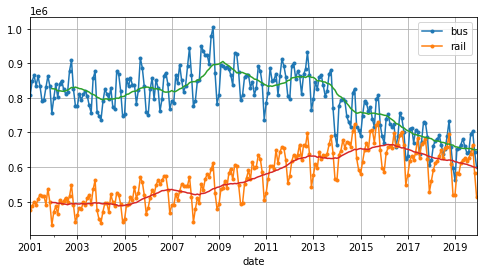

In [8]:
period = slice("2001", "2019")
df_monthly = df.resample("M").mean()
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8,4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

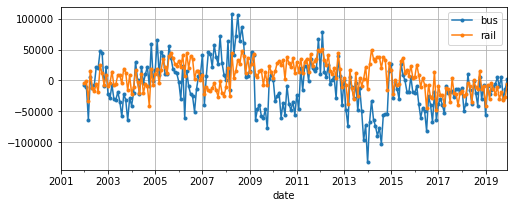

In [9]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8,3))
plt.show()

### The ARMA Model Family

In [10]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
             order=(1,0,0),
             seasonal_order=(0,1,1,7))
model = model.fit()
y_pred = model.forecast()
y_pred

2019-06-01    427758.626282
Freq: D, dtype: float64

In [11]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today], 
                  order=(1,0,0),
                  seasonal_order=(0,1,1,7))
    model = model.fit()
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()
mae

32040.720091160038

### Preparing the Data for Machine Learning Models

In [12]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],
    sequence_length=3,
    batch_size=2
)

2022-12-07 10:41:07.961420: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-07 10:41:16.017430: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [14]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


2022-12-07 10:41:16.283574: W tensorflow/core/framework/dataset.cc:769] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


In [15]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [16]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [17]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5])>)]

In [18]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [19]:
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:1],
    sequence_length=seq_length,
    batch_size=32
)

### Forecasting Using a Linear Model

In [21]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True
)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500,
                   callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 1s 5ms/step - loss: 0.1103 - mae: 0.3568
Epoch 2/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0124 - mae: 0.1200
Epoch 3/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0095 - mae: 0.1027
Epoch 4/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0084 - mae: 0.0973
Epoch 5/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0082 - mae: 0.0969
Epoch 6/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0062 - mae: 0.0822
Epoch 7/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0060 - mae: 0.0803
Epoch 8/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0058 - mae: 0.0803
Epoch 9/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0050 - mae: 0.0726
Epoch 10/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0048 - mae: 0.0715
Epoch 11/500
33/33 [==============================] - 0s 5m

Epoch 29/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0033 - mae: 0.0566
Epoch 30/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0033 - mae: 0.0555
Epoch 31/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0032 - mae: 0.0534
Epoch 32/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0033 - mae: 0.0552
Epoch 33/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0031 - mae: 0.0524
Epoch 34/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0030 - mae: 0.0506
Epoch 35/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0032 - mae: 0.0542
Epoch 36/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0031 - mae: 0.0520
Epoch 37/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0030 - mae: 0.0513
Epoch 38/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0030 - mae: 0.0516
Epoch 39/500
33/33 [==============================

Epoch 57/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0029 - mae: 0.0499
Epoch 58/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0029 - mae: 0.0489
Epoch 59/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0029 - mae: 0.0504
Epoch 60/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0027 - mae: 0.0462
Epoch 61/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0027 - mae: 0.0459
Epoch 62/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0028 - mae: 0.0471
Epoch 63/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0034 - mae: 0.0567
Epoch 64/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0028 - mae: 0.0480
Epoch 65/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0036 - mae: 0.0609
Epoch 66/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0027 - mae: 0.0467
Epoch 67/500
33/33 [==============================

Epoch 85/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0026 - mae: 0.0448
Epoch 86/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0440
Epoch 87/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0027 - mae: 0.0465
Epoch 88/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0443
Epoch 89/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0030 - mae: 0.0517
Epoch 90/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0028 - mae: 0.0492
Epoch 91/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0026 - mae: 0.0433
Epoch 92/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0027 - mae: 0.0460
Epoch 93/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0027 - mae: 0.0462
Epoch 94/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0027 - mae: 0.0457
Epoch 95/500
33/33 [==============================

Epoch 113/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0437
Epoch 114/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0446
Epoch 115/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0027 - mae: 0.0453
Epoch 116/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0026 - mae: 0.0444
Epoch 117/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0449
Epoch 118/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0443
Epoch 119/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0431
Epoch 120/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0025 - mae: 0.0433
Epoch 121/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0025 - mae: 0.0423
Epoch 122/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0432
Epoch 123/500
33/33 [===================

33/33 [==============================] - 0s 5ms/step - loss: 0.0026 - mae: 0.0446
Epoch 141/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0432
Epoch 142/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0435
Epoch 143/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0028 - mae: 0.0478
Epoch 144/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0035 - mae: 0.0579
Epoch 145/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0028 - mae: 0.0472
Epoch 146/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0451
Epoch 147/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0025 - mae: 0.0442
Epoch 148/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0026 - mae: 0.0442
Epoch 149/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0450
Epoch 150/500
33/33 [==============================] -

33/33 [==============================] - 0s 4ms/step - loss: 0.0028 - mae: 0.0471
Epoch 169/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0450
Epoch 170/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0440
Epoch 171/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0025 - mae: 0.0429
Epoch 172/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0027 - mae: 0.0456
Epoch 173/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0028 - mae: 0.0485
Epoch 174/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0037 - mae: 0.0626
Epoch 175/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0449
Epoch 176/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0436
Epoch 177/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0027 - mae: 0.0462
Epoch 178/500
33/33 [==============================] -

33/33 [==============================] - 0s 4ms/step - loss: 0.0025 - mae: 0.0428
Epoch 197/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0450
Epoch 198/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0025 - mae: 0.0431
Epoch 199/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0028 - mae: 0.0453
Epoch 200/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0448
Epoch 201/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0026 - mae: 0.0431
Epoch 202/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0027 - mae: 0.0455
Epoch 203/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0025 - mae: 0.0436
Epoch 204/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0027 - mae: 0.0453
Epoch 205/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0026 - mae: 0.0455
Epoch 206/500
33/33 [==============================] -

33/33 [==============================] - 0s 4ms/step - loss: 0.0027 - mae: 0.0462
Epoch 225/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0027 - mae: 0.0472
Epoch 226/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0027 - mae: 0.0461
Epoch 227/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0454
Epoch 228/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0027 - mae: 0.0450
Epoch 229/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0027 - mae: 0.0473
Epoch 230/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0436
Epoch 231/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0032 - mae: 0.0537
Epoch 232/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0032 - mae: 0.0543
Epoch 233/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0028 - mae: 0.0501
Epoch 234/500
33/33 [==============================] -

33/33 [==============================] - 0s 4ms/step - loss: 0.0029 - mae: 0.0490
Epoch 253/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0029 - mae: 0.0490
Epoch 254/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0025 - mae: 0.0422
Epoch 255/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0025 - mae: 0.0429
Epoch 256/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0451
Epoch 257/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0025 - mae: 0.0431
Epoch 258/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0025 - mae: 0.0425
Epoch 259/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0028 - mae: 0.0482
Epoch 260/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0027 - mae: 0.0468
Epoch 261/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0028 - mae: 0.0486
Epoch 262/500
33/33 [==============================] -

33/33 [==============================] - 0s 4ms/step - loss: 0.0028 - mae: 0.0479
Epoch 281/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0027 - mae: 0.0461
Epoch 282/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0444
Epoch 283/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0437
Epoch 284/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0443
Epoch 285/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0026 - mae: 0.0443
Epoch 286/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0026 - mae: 0.0436
Epoch 287/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0025 - mae: 0.0425
Epoch 288/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0027 - mae: 0.0469
Epoch 289/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0448
Epoch 290/500
33/33 [==============================] -

33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0441
Epoch 309/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0440
Epoch 310/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0025 - mae: 0.0429
Epoch 311/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0455
Epoch 312/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0026 - mae: 0.0428
Epoch 313/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0025 - mae: 0.0420
Epoch 314/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0026 - mae: 0.0456
Epoch 315/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0429
Epoch 316/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0025 - mae: 0.0420
Epoch 317/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0449
Epoch 318/500
33/33 [==============================] -

33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0448
Epoch 337/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0027 - mae: 0.0448
Epoch 338/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0440
Epoch 339/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0027 - mae: 0.0454
Epoch 340/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0440
Epoch 341/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0443
Epoch 342/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0450
Epoch 343/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0025 - mae: 0.0431
Epoch 344/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0457
Epoch 345/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0027 - mae: 0.0475
Epoch 346/500
33/33 [==============================] -

33/33 [==============================] - 0s 4ms/step - loss: 0.0032 - mae: 0.0534
Epoch 365/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0452
Epoch 366/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0025 - mae: 0.0437
Epoch 367/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0025 - mae: 0.0427
Epoch 368/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0027 - mae: 0.0459
Epoch 369/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0438
Epoch 370/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0443
Epoch 371/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0438
Epoch 372/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0029 - mae: 0.0510
Epoch 373/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0441
Epoch 374/500
33/33 [==============================] -

33/33 [==============================] - 0s 4ms/step - loss: 0.0032 - mae: 0.0546
Epoch 393/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0429
Epoch 394/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0027 - mae: 0.0444
Epoch 395/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0028 - mae: 0.0470
Epoch 396/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0025 - mae: 0.0434
Epoch 397/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0025 - mae: 0.0427
Epoch 398/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0025 - mae: 0.0429
Epoch 399/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0025 - mae: 0.0423
Epoch 400/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0027 - mae: 0.0455
Epoch 401/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0027 - mae: 0.0466
Epoch 402/500
33/33 [==============================] -

33/33 [==============================] - 0s 4ms/step - loss: 0.0025 - mae: 0.0435
Epoch 421/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0440
Epoch 422/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0025 - mae: 0.0433
Epoch 423/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0446
Epoch 424/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0025 - mae: 0.0437
Epoch 425/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0443
Epoch 426/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0436
Epoch 427/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0025 - mae: 0.0431
Epoch 428/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0458
Epoch 429/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0446
Epoch 430/500
33/33 [==============================] -

33/33 [==============================] - 0s 4ms/step - loss: 0.0032 - mae: 0.0542
Epoch 449/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0027 - mae: 0.0458
Epoch 450/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0029 - mae: 0.0504
Epoch 451/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0440
Epoch 452/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0029 - mae: 0.0486
Epoch 453/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0449
Epoch 454/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0025 - mae: 0.0424
Epoch 455/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0028 - mae: 0.0484
Epoch 456/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0027 - mae: 0.0446
Epoch 457/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0029 - mae: 0.0503
Epoch 458/500
33/33 [==============================] -

33/33 [==============================] - 0s 5ms/step - loss: 0.0025 - mae: 0.0423
Epoch 477/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0446
Epoch 478/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0027 - mae: 0.0458
Epoch 479/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0029 - mae: 0.0503
Epoch 480/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0029 - mae: 0.0503
Epoch 481/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0025 - mae: 0.0425
Epoch 482/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0025 - mae: 0.0419
Epoch 483/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0028 - mae: 0.0477
Epoch 484/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0026 - mae: 0.0448
Epoch 485/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0025 - mae: 0.0443
Epoch 486/500
33/33 [==============================] -

### Forecasting using a simple RNN

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [25]:
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)
])

In [27]:
univar_model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = univar_model.fit(train_ds, validation_data=valid_ds, epochs=500,
                   callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0930 - mae: 0.2993
Epoch 2/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0073 - mae: 0.0936
Epoch 3/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0043 - mae: 0.0653
Epoch 4/500
33/33 [==============================] - 0s 14ms/step - loss: 0.0037 - mae: 0.0570
Epoch 5/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0033 - mae: 0.0524
Epoch 6/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0033 - mae: 0.0521
Epoch 7/500
33/33 [==============================] - 0s 14ms/step - loss: 0.0031 - mae: 0.0493
Epoch 8/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0031 - mae: 0.0492
Epoch 9/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0031 - mae: 0.0492
Epoch 10/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0029 - mae: 0.0471
Epoch 11/500
33/33 [=============================

Epoch 29/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0027 - mae: 0.0447
Epoch 30/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0027 - mae: 0.0459
Epoch 31/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0027 - mae: 0.0452
Epoch 32/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0026 - mae: 0.0425
Epoch 33/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0027 - mae: 0.0445
Epoch 34/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0026 - mae: 0.0433
Epoch 35/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0025 - mae: 0.0412
Epoch 36/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0025 - mae: 0.0433
Epoch 37/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0026 - mae: 0.0438
Epoch 38/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0027 - mae: 0.0458
Epoch 39/500
33/33 [====================

Epoch 57/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0025 - mae: 0.0422
Epoch 58/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0025 - mae: 0.0405
Epoch 59/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0024 - mae: 0.0403
Epoch 60/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0024 - mae: 0.0402
Epoch 61/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0025 - mae: 0.0405
Epoch 62/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0025 - mae: 0.0427
Epoch 63/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0024 - mae: 0.0408
Epoch 64/500
33/33 [==============================] - 1s 15ms/step - loss: 0.0025 - mae: 0.0410
Epoch 65/500
33/33 [==============================] - 1s 13ms/step - loss: 0.0024 - mae: 0.0405
Epoch 66/500
33/33 [==============================] - 1s 13ms/step - loss: 0.0026 - mae: 0.0420
Epoch 67/500
33/33 [====================

Epoch 85/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0024 - mae: 0.0413
Epoch 86/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0024 - mae: 0.0411
Epoch 87/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0024 - mae: 0.0401
Epoch 88/500
33/33 [==============================] - 1s 16ms/step - loss: 0.0024 - mae: 0.0400
Epoch 89/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0024 - mae: 0.0415
Epoch 90/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0024 - mae: 0.0415
Epoch 91/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0025 - mae: 0.0427
Epoch 92/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0024 - mae: 0.0413
Epoch 93/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0024 - mae: 0.0398
Epoch 94/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0023 - mae: 0.0391
Epoch 95/500
33/33 [====================

Epoch 113/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0023 - mae: 0.0403
Epoch 114/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0023 - mae: 0.0388
Epoch 115/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0024 - mae: 0.0404
Epoch 116/500
33/33 [==============================] - 0s 14ms/step - loss: 0.0023 - mae: 0.0393
Epoch 117/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0025 - mae: 0.0420
Epoch 118/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0023 - mae: 0.0396
Epoch 119/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0023 - mae: 0.0389
Epoch 120/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0023 - mae: 0.0386
Epoch 121/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0023 - mae: 0.0397
Epoch 122/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0024 - mae: 0.0388
Epoch 123/500
33/33 [=========

33/33 [==============================] - 0s 11ms/step - loss: 0.0023 - mae: 0.0392
Epoch 141/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0025 - mae: 0.0421
Epoch 142/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0023 - mae: 0.0402
Epoch 143/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0023 - mae: 0.0377
Epoch 144/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0023 - mae: 0.0396
Epoch 145/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0023 - mae: 0.0401
Epoch 146/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0023 - mae: 0.0412
Epoch 147/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0023 - mae: 0.0387
Epoch 148/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0023 - mae: 0.0399
Epoch 149/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0024 - mae: 0.0416
Epoch 150/500
33/33 [=======================

33/33 [==============================] - 0s 11ms/step - loss: 0.0023 - mae: 0.0388
Epoch 169/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0023 - mae: 0.0405
Epoch 170/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0023 - mae: 0.0387
Epoch 171/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0022 - mae: 0.0384
Epoch 172/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0022 - mae: 0.0388
Epoch 173/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0024 - mae: 0.0413
Epoch 174/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0023 - mae: 0.0395
Epoch 175/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0022 - mae: 0.0392
Epoch 176/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0022 - mae: 0.0386
Epoch 177/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0022 - mae: 0.0384
Epoch 178/500
33/33 [=======================

33/33 [==============================] - 0s 13ms/step - loss: 0.0022 - mae: 0.0373
Epoch 197/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0022 - mae: 0.0382
Epoch 198/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0375
Epoch 199/500
33/33 [==============================] - 1s 14ms/step - loss: 0.0022 - mae: 0.0378
Epoch 200/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0023 - mae: 0.0383
Epoch 201/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0022 - mae: 0.0394
Epoch 202/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0022 - mae: 0.0381
Epoch 203/500
33/33 [==============================] - 0s 14ms/step - loss: 0.0023 - mae: 0.0395
Epoch 204/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0022 - mae: 0.0391
Epoch 205/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0023 - mae: 0.0423
Epoch 206/500
33/33 [=======================

33/33 [==============================] - 0s 11ms/step - loss: 0.0022 - mae: 0.0386
Epoch 225/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0023 - mae: 0.0410
Epoch 226/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0022 - mae: 0.0378
Epoch 227/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0023 - mae: 0.0388
Epoch 228/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0022 - mae: 0.0388
Epoch 229/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0372
Epoch 230/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0023 - mae: 0.0393
Epoch 231/500
33/33 [==============================] - 0s 14ms/step - loss: 0.0021 - mae: 0.0385
Epoch 232/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0021 - mae: 0.0378
Epoch 233/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0368
Epoch 234/500
33/33 [=======================

33/33 [==============================] - 0s 12ms/step - loss: 0.0022 - mae: 0.0379
Epoch 253/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0021 - mae: 0.0378
Epoch 254/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0369
Epoch 255/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0020 - mae: 0.0364
Epoch 256/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0361
Epoch 257/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0021 - mae: 0.0379
Epoch 258/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0387
Epoch 259/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0368
Epoch 260/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0382
Epoch 261/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0376
Epoch 262/500
33/33 [=======================

33/33 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0374
Epoch 281/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0361
Epoch 282/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0371
Epoch 283/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0370
Epoch 284/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0369
Epoch 285/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0376
Epoch 286/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0376
Epoch 287/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0379
Epoch 288/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0022 - mae: 0.0402
Epoch 289/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0381
Epoch 290/500
33/33 [=======================

33/33 [==============================] - 0s 11ms/step - loss: 0.0020 - mae: 0.0354
Epoch 309/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0021 - mae: 0.0366
Epoch 310/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0020 - mae: 0.0364
Epoch 311/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0378
Epoch 312/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0021 - mae: 0.0380
Epoch 313/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0021 - mae: 0.0383
Epoch 314/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0021 - mae: 0.0375
Epoch 315/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0020 - mae: 0.0357
Epoch 316/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0021 - mae: 0.0364
Epoch 317/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0020 - mae: 0.0358
Epoch 318/500
33/33 [=======================

33/33 [==============================] - 0s 11ms/step - loss: 0.0020 - mae: 0.0353
Epoch 337/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0020 - mae: 0.0367
Epoch 338/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0375
Epoch 339/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0393
Epoch 340/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0020 - mae: 0.0363
Epoch 341/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0397
Epoch 342/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0022 - mae: 0.0407
Epoch 343/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0020 - mae: 0.0369
Epoch 344/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0020 - mae: 0.0362
Epoch 345/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0020 - mae: 0.0370
Epoch 346/500
33/33 [=======================

33/33 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0392
Epoch 365/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0021 - mae: 0.0387
Epoch 366/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0020 - mae: 0.0365
Epoch 367/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0019 - mae: 0.0368
Epoch 368/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0020 - mae: 0.0381
Epoch 369/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0021 - mae: 0.0403
Epoch 370/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0019 - mae: 0.0368
Epoch 371/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0020 - mae: 0.0374
Epoch 372/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0020 - mae: 0.0371
Epoch 373/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0020 - mae: 0.0381
Epoch 374/500
33/33 [=======================

33/33 [==============================] - 0s 11ms/step - loss: 0.0019 - mae: 0.0372
Epoch 393/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0019 - mae: 0.0380
Epoch 394/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0019 - mae: 0.0367
Epoch 395/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0018 - mae: 0.0355
Epoch 396/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0019 - mae: 0.0377
Epoch 397/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0018 - mae: 0.0354
Epoch 398/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0019 - mae: 0.0365
Epoch 399/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0018 - mae: 0.0352
Epoch 400/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0019 - mae: 0.0365
Epoch 401/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0020 - mae: 0.0384
Epoch 402/500
33/33 [=======================

33/33 [==============================] - 0s 11ms/step - loss: 0.0018 - mae: 0.0357
Epoch 421/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0019 - mae: 0.0367
Epoch 422/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0019 - mae: 0.0355
Epoch 423/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0018 - mae: 0.0351
Epoch 424/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0019 - mae: 0.0379
Epoch 425/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0018 - mae: 0.0367
Epoch 426/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0019 - mae: 0.0375
Epoch 427/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0019 - mae: 0.0365
Epoch 428/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0018 - mae: 0.0354
Epoch 429/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0018 - mae: 0.0356
Epoch 430/500
33/33 [=======================

33/33 [==============================] - 0s 11ms/step - loss: 0.0018 - mae: 0.0353
Epoch 449/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0018 - mae: 0.0345
Epoch 450/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0017 - mae: 0.0352
Epoch 451/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0018 - mae: 0.0351
Epoch 452/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0017 - mae: 0.0349
Epoch 453/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0017 - mae: 0.0344
Epoch 454/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0018 - mae: 0.0366
Epoch 455/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0018 - mae: 0.0355
Epoch 456/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0018 - mae: 0.0369
Epoch 457/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0018 - mae: 0.0360
Epoch 458/500
33/33 [=======================

33/33 [==============================] - 0s 12ms/step - loss: 0.0019 - mae: 0.0367
Epoch 477/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0018 - mae: 0.0357
Epoch 478/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0018 - mae: 0.0361
Epoch 479/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0017 - mae: 0.0339
Epoch 480/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0017 - mae: 0.0340
Epoch 481/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0017 - mae: 0.0355
Epoch 482/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0020 - mae: 0.0379
Epoch 483/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0018 - mae: 0.0362
Epoch 484/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0017 - mae: 0.0353
Epoch 485/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0017 - mae: 0.0349
Epoch 486/500
33/33 [=======================

### Forecasting Using a Deep RNN

In [29]:
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

### Forecasting Multivariate Time Series

In [31]:
df_mulvar = df[["bus", "rail"]] / 1e6
df_mulvar["next_day_type"] = df["day_type"].shift(-1)
df_mulvar = pd.get_dummies(df_mulvar)

In [32]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [35]:
train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32)

In [36]:
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

### Forecasting Several Time Steps Ahead

One way to forecast multiple steps would be to loop over each prediction, using it as input to the next prediction. This works ok for a small model, but errors tend to accumulate.

In [40]:
import numpy as np
X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 34ms/step


Or you could train the RNN to predict the net 14 values in one shot. This will not accumulate errors, like the loop did.

In [42]:
def split_inputs_and_targets(multivar_series, ahead=14, target_col=1):
    return multivar_series[:, :-ahead], multivar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length+14,
    batch_size=32,
    shuffle=True,
    seed=42).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [43]:
ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [44]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
Y_pred = ahead_model.predict(X)

1/1 [==============================] - 0s 156ms/step


### Forecasting using a Sequence-to-Sequence Model

In [45]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]])>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]])>]

In [46]:
dataset = dataset.map(lambda S: (S[:, 0], S[:,1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]])>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4])>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]])>)]

In [47]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                      batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [48]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [49]:
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [50]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]

1/1 [==============================] - 0s 184ms/step
